# Train U-Net on the CAS Landslide Detection Dataset

*Authors: Abdelouahed Drissi*

## Dataset

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from losses import dice_loss

### Function to read the image file

In [ ]:
def load_image_file(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_png(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

### Loading the dataset

In [ ]:
# Dataset paths
train_image_dir = "./dataset/train/images"
train_mask_dir = "./dataset/train/masks"
valid_image_dir = "./dataset/validation/images"
valid_mask_dir = "./dataset/validation/masks"
test_image_dir = "./dataset/test/images"
test_mask_dir = "./dataset/test/masks"

# Load datasets and match images with masks
def load_data(image_dir, mask_dir):
    image_names = sorted(os.listdir(image_dir))
    mask_names = sorted(os.listdir(mask_dir))
    pairs = []
    for img_name in image_names:
        mask_name = img_name.replace("image", "mask")
        if mask_name in mask_names:
            pairs.append((os.path.join(image_dir, img_name), os.path.join(mask_dir, mask_name)))
    data = [load_image_file(image_path, mask_path) for image_path, mask_path in pairs]
    return data

data_train = load_data(train_image_dir, train_mask_dir)
data_valid = load_data(valid_image_dir, valid_mask_dir)
data_test = load_data(test_image_dir, test_mask_dir)

len(data_train), len(data_valid), len(data_test)

### Normalization and Image Resizing

In [ ]:
# Normalize and preprocess images and masks
image_size = 256
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    return ({"pixel_values": input_image}, input_mask)

In [ ]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]
test_data = [load_image(datapoint) for datapoint in data_test]

### Build input pipeline

In [ ]:
batch_size = 4
auto = tf.data.AUTOTUNE
# Create dataset generators
def generator(data):
    for datapoint in data:
        yield datapoint


train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_data),
    output_types=({"pixel_values": tf.float32}, tf.int32),
    output_shapes=({"pixel_values": (image_size, image_size, 3)}, (image_size, image_size,1))
).cache().shuffle(batch_size * 10).batch(batch_size).repeat().prefetch(auto)

valid_ds = tf.data.Dataset.from_generator(
    lambda: generator(valid_data),
    output_types=({"pixel_values": tf.float32}, tf.int32),
    output_shapes=({"pixel_values": (image_size, image_size, 3)}, (image_size, image_size,1))
).batch(batch_size).repeat().prefetch(auto)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator(test_data),
    output_types=({"pixel_values": tf.float32}, tf.int32),
    output_shapes=({"pixel_values": (image_size, image_size, 3)}, (image_size, image_size,1))
).batch(batch_size).prefetch(auto)


In [ ]:
print(train_ds.element_spec)


## Model

In [ ]:
# Image bands
img_bands = 3

# Loss function
loss=dice_loss

def unet(lr,filtersFirstLayer,input_size = (image_size,image_size,img_bands)):
    inputs = Input(input_size, name="pixel_values")
    conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(inputs)
    conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool1)
    conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool2)
    conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool3)
    conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool4)
    conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv5)
    
    up6 = Conv2D(filtersFirstLayer*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge6)
    conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv6)
    
    up7 = Conv2D(filtersFirstLayer*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge7)
    conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv7)
    
    up8 = Conv2D(filtersFirstLayer*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge8)
    conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv8)
    
    up9 = Conv2D(filtersFirstLayer, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge9)
    conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs=inputs,  outputs=conv10)
    
    model.compile(optimizer = Adam(learning_rate = lr), loss = loss)
    print("Model input shape:", model.input_shape)  # Expected: (None, image_size, image_size, 3)

    return model

In [ ]:
# Training and evaluation loop parameters
filters = [4, 8, 16, 32]
learning_rates = [ 10e-3, 5e-4, 10e-4, 5e-5, 10e-5]
batch_sizes = [4, 8, 16, 32]
epochs = 5

steps_per_epoch = len(train_data) // batch_size  # Number of batches per epoch


In [ ]:

for filter_count in filters:
    for lr in learning_rates:
        for batch in batch_sizes:
            print(f"Filters: {filter_count}, Learning Rate: {lr}, Batch Size: {batch}")
            model = unet(lr=lr, filtersFirstLayer=filter_count, input_size=(256, 256, 3))
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
            
            # Save best model during training
            checkpoint_path = f'./data/model/unet/weights/unet_filters_{filter_count}_batch_{batch}_lr_{lr}.keras'
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

            
            # Train the model
            history = model.fit(
                train_ds,
                validation_data=valid_ds,
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_steps=len(valid_data) // batch_size,
                callbacks=[early_stop, model_checkpoint],
                verbose=1
            )

### Testing and Metric Comparison Across Checkpoints

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:

results_dict = {
    "model": [], "batch_size": [], "learning_rate": [], "filters": [],
    "precision": [], "recall": [], "f1_score": [], "iou_score": []
}
# Metric functions (add these if not using a package like segmentation_models)
def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.round(y_true * y_pred))
    predicted_positives = tf.reduce_sum(tf.round(y_pred))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.round(y_true * y_pred))
    possible_positives = tf.reduce_sum(tf.round(y_true))
    return true_positives / (tf.cast(possible_positives,tf.float32) + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def iou_score(y_true, y_pred): 
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

checkpoint_path = f'./data/model/unet/weights'
for filename in os.listdir(checkpoint_path):
    # Only load files with the proper model file extension
    if filename.endswith(".keras"):     
        # Define the model structure
        filter_count = int(filename.split('_')[2])
        lr = float(filename.split('_')[6].split('.keras')[0])
        batch = int(filename.split('_')[4])
        model = unet(lr=lr, filtersFirstLayer=filter_count, input_size=(256, 256, 3))
        
        # Load best model weights
        model.load_weights(os.path.join(checkpoint_path, filename))
        print(f"Evaluating model with checkpoint: {filename}")
        
        # Evaluate on test data
        y_true = []
        y_pred = []
        for sample in test_ds:
            pred = model.predict(sample[0]["pixel_values"], verbose=0)
            y_true.append(sample[1].numpy())
            y_pred.append(pred)
        
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        
         # Ensure both y_true and y_pred have the same shape for metrics
        if y_pred.shape[-1] == 1:
            y_pred = np.squeeze(y_pred, axis=-1)  # Remove the last dimension if it's 1
        if y_true.shape[-1] == 1:
            y_true = np.squeeze(y_true, axis=-1)
            
        # Compute and collect metrics
        precision_val = precision(y_true, y_pred).numpy()
        recall_val = recall(y_true, y_pred).numpy()
        f1_val = f1_score(y_true, y_pred).numpy()
        iou_val = iou_score(y_true, y_pred).numpy()
        
        results_dict["precision"].append(precision_val)
        results_dict["recall"].append(recall_val)
        results_dict["f1_score"].append(f1_val)
        results_dict["iou_score"].append(iou_val)
        
        results_dict["model"].append("U-Net")
        results_dict["batch_size"].append(batch)
        results_dict["learning_rate"].append(lr)
        results_dict["filters"].append(filter_count)
        
# Convert results_dict to DataFrame and save as CSV
results_df = pd.DataFrame(results_dict)
results_df.to_csv("data/model/unet/results/results_unet.csv", index=False)

print("Validation and metric calculation completed, results saved.")

### Sample Predictions (Ground Truth vs. Predicted Masks for model with the best F1_score)

Model input shape: (None, 256, 256, 3)
Plot sample from file: ./data/model/unet/weights/unet_filters_4_batch_4_lr_0.0005.keras


C:\Users\abdrissi\Desktop\Strathclyde\Project\models\CAS_Dataset\LandslideDetection\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


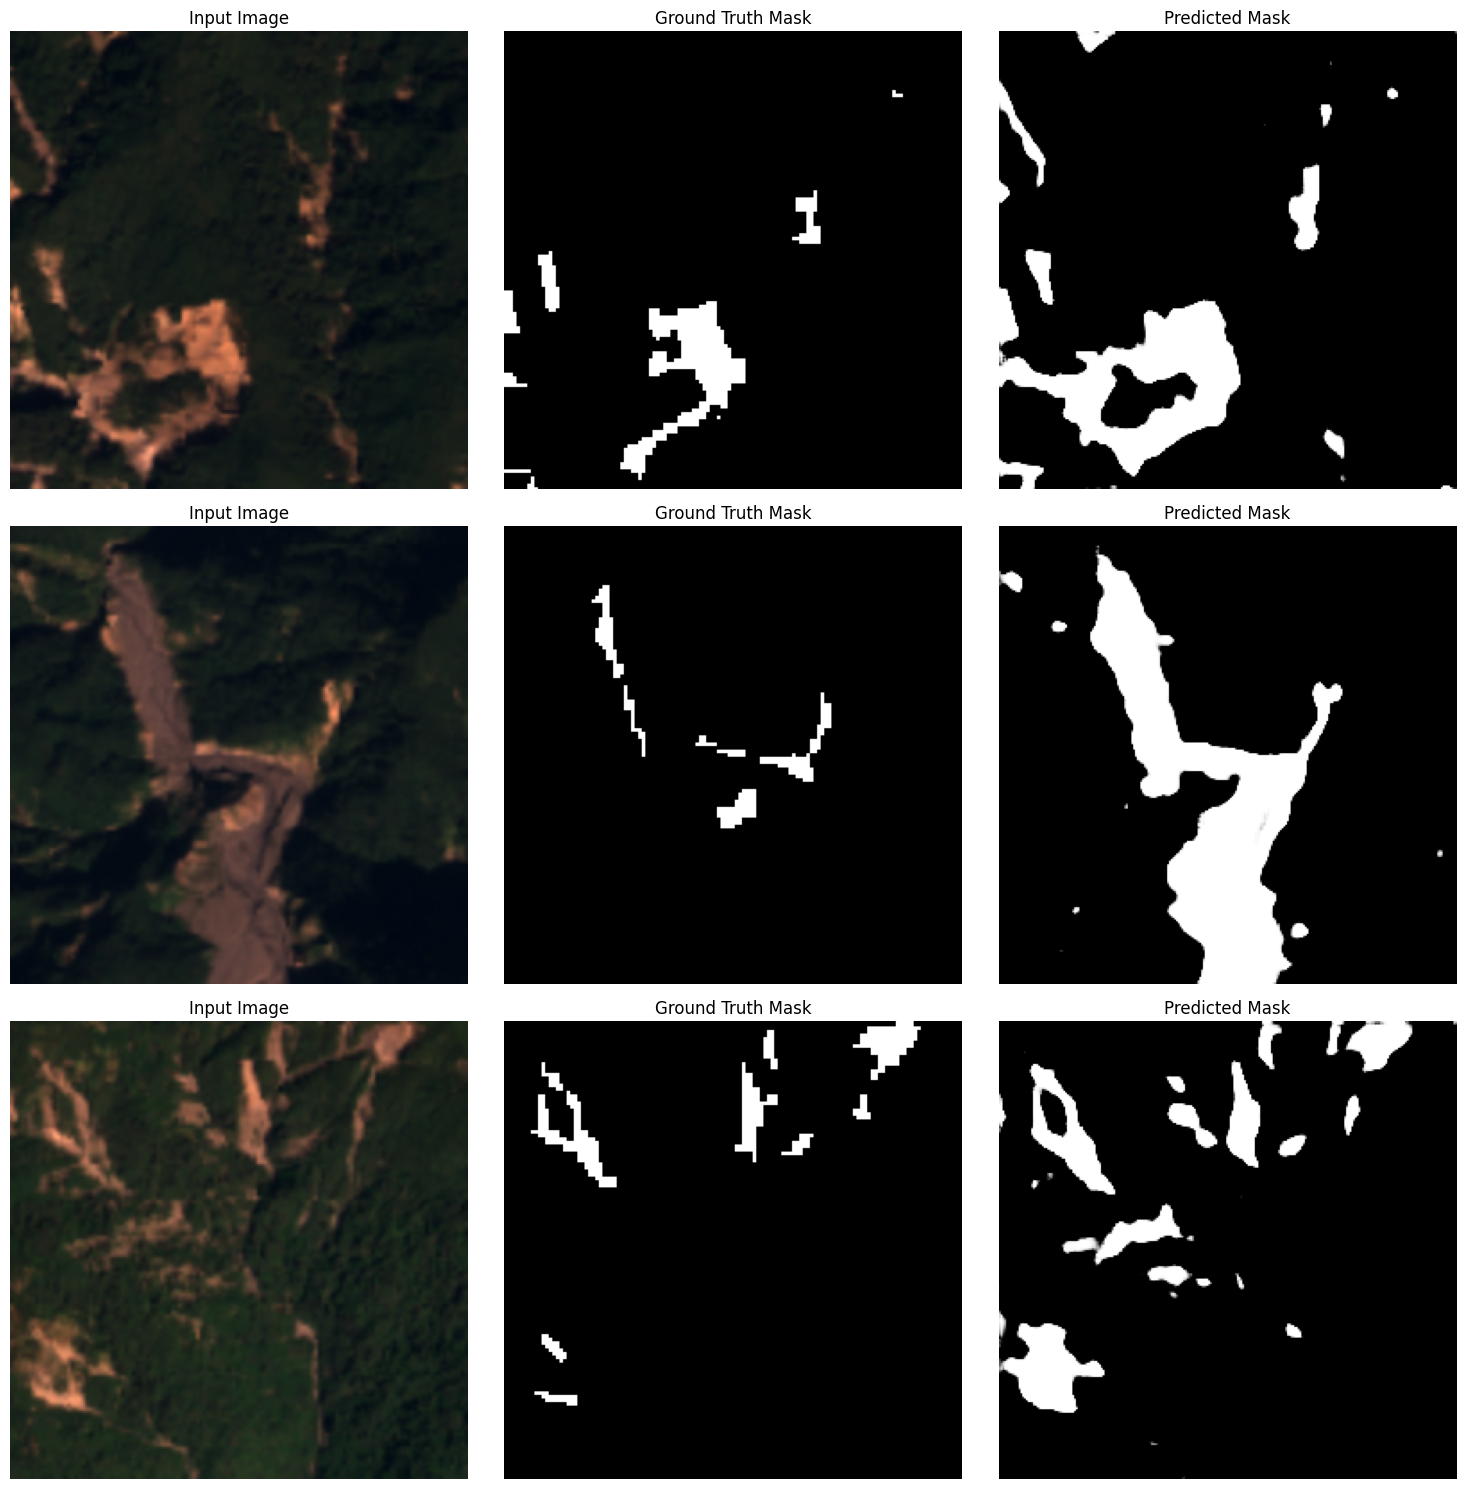

In [60]:
def plot_sample_predictions(test_ds, model, num_samples=3):
    plt.figure(figsize=(15, num_samples * 5))
    
    for i, sample in enumerate(test_ds.take(num_samples)):
        input_image = sample[0]["pixel_values"]  # Taking first image in batch
        ground_truth_mask = sample[1]
        
        # Predict
        pred_mask = model.predict(input_image, verbose=0)
        
        image = input_image.numpy()[0]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Plot input, ground truth, and prediction
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(ground_truth_mask.numpy()[0], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask[0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("data/model/unet/results/sample_predictions.png")
    plt.show()


# Find the model with the best f1_score
df = pd.read_csv("data/model/unet/results/results_unet.csv")
maxIndex = df["iou_score"].idxmax()
filter_count = df["filters"][maxIndex]
lr = df["learning_rate"][maxIndex]
batch_size = df["batch_size"][maxIndex]

filename = f'./data/model/unet/weights/unet_filters_{filter_count}_batch_{batch_size}_lr_{lr}.keras'

# Load best model weights
model = unet(lr=lr, filtersFirstLayer=filter_count, input_size=(256, 256, 3))
model.load_weights(filename)

print(f"Plot sample from file: {filename}")
plot_sample_predictions(test_ds, model)
